# Experiment 3

### Master's Thesis:  Domain Adaptation in Wireless Capsule Endoscopy Diagnosis

#### Author: Èlia FICAPAL VILA

#### Supervisor:  Dr. Santi SEGUÍ

* Model: ResNet with Cross-Entropy Loss
* Trained with: PillCam SB2 images and (or not) PillCam SB2 images
* Testing on: PillCam SB3 images

The second approach consists of a ResNet stacked with a dense layer. The ResNet is used in order to extract the main features to create a rich vector representation of a given size of each image, the embedding. More specifically, the 50-layer ResNet pretrained on ImageNet is considered. 

Once the embedding is computed, it is fed to the dense layer, which will have as many units as number of classes. It ouputs the scores of belonging to each of the classes which, in turn, can be converted into probabilities applying a softmax function. In order to measure the performance of the classification model and then optimise the parameters, the cross-entropy loss is used. 

Moreover, L2-regularisation is used to prevent overfitting. 

The following image shows the general pipeline.



![alt text](images/CE_model.png "Title")


The model is trained using the majority of images obtained from PillCam SB2, but also some PillCam SB3 images will be added. First of all, the model trained with 2000 SB2 images per class will be considered. Then, 5, 10 and 25 SB3 images per class will be added for training. In every batch, 50 and 14 SB2 and SB2, respectively, images will be included. Data augmentation such as rotations and flips will be applied to the SB3 images. All these models will be evaluated using 25 SB3 images per class.

In this notebook it is shown how to train and evaluate the model. Also, some results ready to be analysed are plotted in the end.

In [1]:
#Libraries

import tensorflow as tf
import numpy as np
import random
import os
import pickle
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Selecting the parameters

First, we give values to the parameters. The majority of parameters will stay the same for all the experiments (such as the image shape, the optimiser, the learning rate, etc.). However, there are other values that should be modified.

In this case, we will:
* use 2000 SB2 images per class for training $\Longrightarrow$ params['train-csize-SB2']=2000
* use 0 SB2 images per class for testing $\Longrightarrow$ params['eval-csize-SB2']=0
* use 0,5,10 or 25 SB3 images per class for training $\Longrightarrow$ params['train-csize-SB3']=0,5,10 or 25
* use 25 SB2 images per class for testing $\Longrightarrow$ params['eval-csize-SB3']=25
* test on SB2 images $\Longrightarrow$ params['eval']='SB3'
* not include the triplet loss $\Longrightarrow$ params['include-triplet-loss']=False

Since we want to use the model from Experiment 1, we would have to specify the directory containing the checkpoints in params['warm-dir'] and also change params['warm-dir-short'] so that it can be included in the name of the directory.

In [9]:
params = {
    
#Parameters for the reader
    'train-csize-SB2' : 2000,
    'eval-csize-SB2' : 0,
    'train-csize-SB3' : 0,
    'eval-csize-SB3' : 25,
    'eval' : 'SB3', #can be SB2 or SB3
    
# Parser parameters
    'image-shape' : (256,256,3), 

# Optimizer parameters 
    'optimizer': 'SGD', #Adagrad, Adam, SGD, MomentumOptimizer
    'learning-rate': 1e-4,

# Embedding parameters
    'embedding-size': 2048,

# Model
    'resnet-size' : 50,
    'num-classes' : 7,
    'train-only-last-layer' : True,
    'include-classifier': True,

# Losses
    'cross-entropy': True,
    'include-triplet-loss': False,
    'triplet-strategy': "batch-all", # batch-all, batch-hard, mixed
    'triplet-margin-strategy' : 'hinge-margin', # 'hing-margin, soft-margin
    'triplet-distance': 'euclid', # euclid, cosine
    'margin' : 0.2,
    'include-l2-loss': True,
    'weight-decay': 2e-4, 


# Sumaries
    'with-scalars': True,
    'with-histograms': False,
    'with-images': False,

# Run Model
    'shuffle' : False,
    'batch-size': 64, 
    'delete-existing': False, 
    'warm-dir': None,
    'warm-dir-short': 'noTL', ##TL, noTL or None
    'prefetch': 64,
    'train-epochs': 1,  
    'eval-epochs': 1, 
    
#Others    
    'gpu' : '/gpu:1',
    'save-summary-steps' : 50,
    
# Eval Model
    'fetch-tensors': ['confusion_matrix','embeddings','predictions','labels','probabilities']   
}

The directory where everything in the model will be saved is defined as follows.

In [10]:
if params['include-triplet-loss']:
    params['model-dir'] = 'experiments/SB2{}-{}_SB3{}-{}_BS{}_emb{}_LR{}_{}_{}_marg{}_WD{}'.format(params['train-csize-SB2'],params['eval-csize-SB2'],
                                                                                                    params['train-csize-SB3'],params['eval-csize-SB3'],
                                                                                                    params['batch-size'],params['embedding-size'],
                                                                                                    params['learning-rate'], params['optimizer'],
                                                                                                    params['triplet-strategy'],
                                                                                                    params['margin'],params['warm-dir-short'])
else:
    params['model-dir'] = 'experiments/SB2{}-{}_SB3{}-{}_BS{}_emb{}_LR{}_{}_WD{}'.format(params['train-csize-SB2'],params['eval-csize-SB2'],
                                                                                         params['train-csize-SB3'],params['eval-csize-SB3'],
                                                                                         params['batch-size'],params['embedding-size'],
                                                                                         params['learning-rate'], params['optimizer'],
                                                                                         params['warm-dir-short'])

In [11]:
print(params['model-dir'])

experiments/SB22000-0_SB30-25_BS64_emb2048_LR0.0001_SGD_WDnoTL


## The reader

Using the selected parameters, the reader is used to read data and to define generators for the training and test datasets.

In [12]:
from model.reader import SB2_SB3_reader

reader = SB2_SB3_reader(train_images_SB2 = params['train-csize-SB2'],
                             test_images_SB2=params['eval-csize-SB2'],
                             train_images_SB3 = params['train-csize-SB3'],
                             eval_on = params['eval'],
                             batch_size=params['batch-size'],
                             shape = params['image-shape'])

reader.define_train_test_SB2(42) #split images from intestins into train and test

params['train-num-samples'] = len(reader.train_key_SB2) + len(reader.SB3_train) #number of training images
params['num-samples'] = len(reader.test_key_SB2) + len(reader.SB3_test) #number of testing images
print("Training samples:",params['train-num-samples'], "Testing samples:",params['num-samples'])

Training samples: 14000 Testing samples: 150


## The model

The neural network is defined using both the selected parameters and the reader that has been just defined.

In [6]:
from model.network import Network

net = Network(params, reader)

## Training the model

The model trains using the following command performing a certain number of epochs defined in params['train-epochs']. If there is already one model with the same directory name, it can recover that model and start training using its weights.

It also evaluates the model every a certain number of epochs, which is defined in params['eval-epochs].

In [7]:
net.run_model(wait = True, save_results = False)  
#For creating this notebook, only one epoch has been performed.

experiments/SB22000-0_SB30-25_BS64_emb2048_LR0.0001_SGD_WDnoTL
Target model directory: experiments/SB22000-0_SB30-25_BS64_emb2048_LR0.0001_SGD_WDnoTL
INFO:tensorflow:Using config: {'_model_dir': 'experiments/SB22000-0_SB30-25_BS64_emb2048_LR0.0001_SGD_WDnoTL', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 1000000000.0, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
log_device_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff589b09198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_r

iterating...


/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


## Evaluating the model

The following command is used in order to evaluate the model on the test dataset and obtain the results specified in params['fetch-tensors'].

In [13]:
net.eval_model(save_results = True) 

experiments/SB22000-0_SB30-25_BS64_emb2048_LR0.0001_SGD_WDnoTL
Found candidate model at: experiments/SB22000-0_SB30-25_BS64_emb2048_LR0.0001_SGD_WDnoTL
Target model directory: experiments/SB22000-0_SB30-25_BS64_emb2048_LR0.0001_SGD_WDnoTL


/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Uncomment the following command to save the results using pickle.

In [14]:
#pickle.dump(net.results, open( "res_experiments/res_{}-{}_{}-{}_noTL.p".format(params['train-csize-SB2'],params['eval-csize-SB2'],
#                                                                      params['train-csize-SB3'],params['eval-csize-SB3']),
#                                                                      "wb" ) )

## Analysing the results

The following cells will be used to analyse the results obtained from evaluating our model in the test dataset. 

First of all, the results that we previously saved from our trained model are uploaded using pickle from the "res_experiments" folder. Then a Python class is built, and it will be used to plot the results. Then, we will show:

### 1) Normalised confusion matrix

The normalised confusion matrix $M = (m_{i,j})_{1 \leq i,j \leq 7}$ that will be plotted has elements defined as $$m_{i,j} = 100 \frac{Pj}{R_i},$$ where $P_j$ is the number of images classified by the model as class $j$, whereas $R_i$ is the number of actual images belonging to class $i$. 

The classes correspond to:

In [15]:
ij = [1,2,3,4,5,6,7]
classes = ['Bubbles','Clear Blob','Dilated','Turbid','Undefined','Wall','Wrinkle']
df = pd.DataFrame(data={'i,j':ij,'Class':classes},index=None).set_index('i,j')
df

,Class
"i,j",
1,Bubbles
2,Clear Blob
3,Dilated
4,Turbid
5,Undefined
6,Wall
7,Wrinkle


### 2) Plot using different colours

Once the embeddings of the images in the test dataset are obtained by the model, their dimensionality can be reduced using Uniform Manifold Approximation and Projection (UMAP) to two-dimensional vectors. However, it is important to remark that these vectors are just a projection and thus not nearly all the information is included. Actually, if the embedding size is 2048, this means that 2046 components are lost.

This chart is a scatter plot using a different colour per class and a different marker if the classification is right or wrong. The dot indicates that the image has been correctly classfied, and the cross otherwise.

### 3) Plot using images

Again, the UMAP projections of the embeddings are used. In this case, the markers are the actual images. The previous plot can be used to know to which class belongs each image. 

This chart helps to visually identify which features the model uses to match an image with a label.

### 1st experiment: adding 0 SB3 images for training

In [16]:
name='res_{}-{}_{}-{}_noTL'.format(params['train-csize-SB2'],params['eval-csize-SB2'],
                                    params['train-csize-SB3'],params['eval-csize-SB3'])
net_results = pickle.load(open( "res_experiments/{}.p".format(name), "rb" ) )

In [17]:
from model.results import get_results

res = get_results(net_results)

#### 1) Normalised confusion matrix

In [18]:
print(100*res.confusion_matrix_norm.round(4))

[[  0.   0.   0. 100.   0.   0.   0.]
 [  0.   4.   0.  88.   0.   0.   8.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 100.   0.   0.   0.]
 [  0.   0.  28.  56.  12.   0.   4.]
 [  0.   0.   8.  92.   0.   0.   0.]
 [  0.   0.   0.  40.  12.   0.  48.]]


#### 2) Plot using different colours

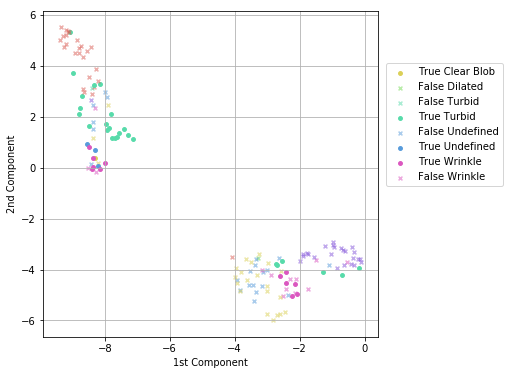

In [19]:
res.plot_colours(save=False,legend=True,filename="colours_{}".format(name))

#### 3) Plot using images

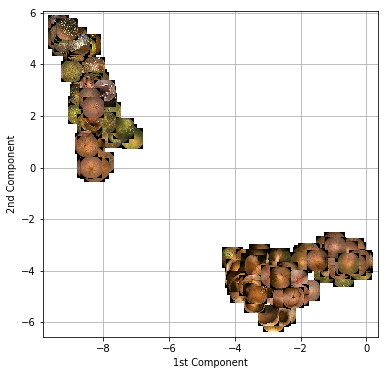

In [20]:
res.plot_images(save=False,
                eval_on=params['eval'],train_size=params['train-csize-SB2'],test_size=params['eval-csize-SB2'],
                filename="images_{}".format(name))

### 2nd experiment: adding 5 SB3 images for training

In [21]:
params['train-csize-SB3'] = 5

In [22]:
name='res_{}-{}_{}-{}_noTL'.format(params['train-csize-SB2'],params['eval-csize-SB2'],
                                    params['train-csize-SB3'],params['eval-csize-SB3'])
net_results = pickle.load(open( "res_experiments/{}.p".format(name), "rb" ) )
res = get_results(net_results)

#### 1) Normalised confusion matrix

In [23]:
print(100*res.confusion_matrix_norm.round(4))

[[88.  0.  0.  8.  4.  0.  0.]
 [ 0. 52.  0.  0. 16. 16. 16.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 8.  0.  0. 88.  0.  4.  0.]
 [ 0. 24.  0.  8. 52.  4. 12.]
 [ 0.  0.  0.  0.  0. 96.  4.]
 [ 0.  0.  0.  4.  4. 16. 76.]]


#### 2) Plot using different colours

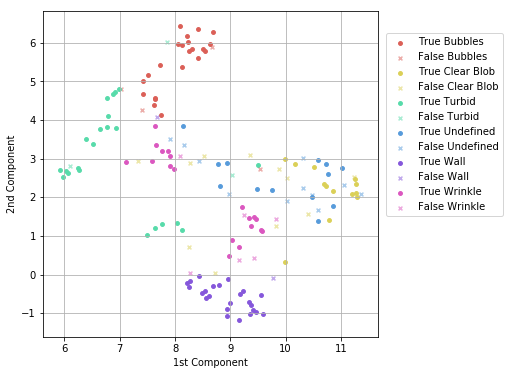

In [24]:
res.plot_colours(save=False,legend=True,filename="colours_{}".format(name))

#### 3) Plot using images

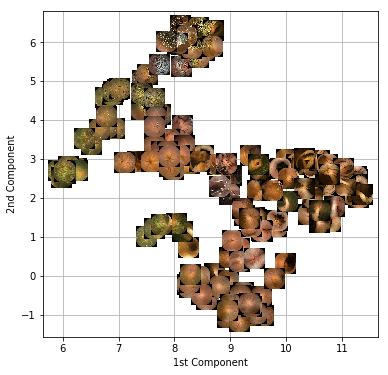

In [25]:
res.plot_images(save=False,
                eval_on=params['eval'],train_size=params['train-csize-SB2'],test_size=params['eval-csize-SB2'],
                filename="images_{}".format(name))

### 3rd experiment: adding 10 SB3 images for training

In [26]:
params['train-csize-SB3'] = 10

In [27]:
name='res_{}-{}_{}-{}_noTL'.format(params['train-csize-SB2'],params['eval-csize-SB2'],
                                    params['train-csize-SB3'],params['eval-csize-SB3'])
net_results = pickle.load(open( "res_experiments/{}.p".format(name), "rb" ) )
res = get_results(net_results)

#### 1) Normalised confusion matrix

In [28]:
print(100*res.confusion_matrix_norm.round(4))

[[96.  0.  0.  4.  0.  0.  0.]
 [ 0. 68.  0.  0.  8.  4. 20.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [12.  0.  0. 88.  0.  0.  0.]
 [ 0. 32.  0.  4. 48.  4. 12.]
 [ 4.  0.  0.  0.  0. 96.  0.]
 [ 0.  0.  0.  4.  0. 12. 84.]]


#### 2) Plot using different colours

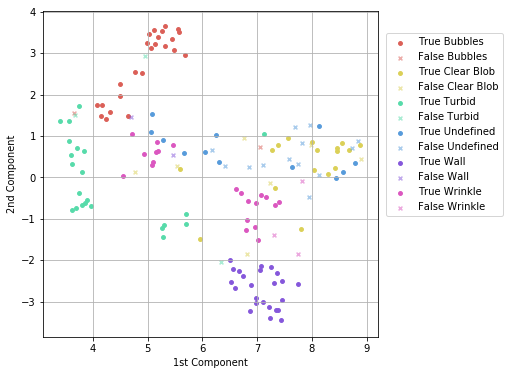

In [29]:
res.plot_colours(save=False,legend=True,filename="colours_{}".format(name))

#### 3) Plot using images

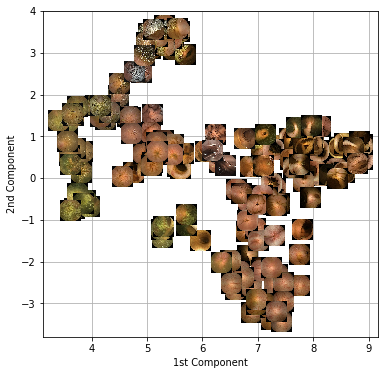

In [30]:
res.plot_images(save=False,
                eval_on=params['eval'],train_size=params['train-csize-SB2'],test_size=params['eval-csize-SB2'],
                filename="images_{}".format(name))

### 4th experiment: adding 25 SB3 images for training

In [31]:
params['train-csize-SB3'] = 25

In [32]:
name='res_{}-{}_{}-{}_noTL'.format(params['train-csize-SB2'],params['eval-csize-SB2'],
                                    params['train-csize-SB3'],params['eval-csize-SB3'])
net_results = pickle.load(open( "res_experiments/{}.p".format(name), "rb" ) )
res = get_results(net_results)

#### 1) Normalised confusion matrix

In [33]:
print(100*res.confusion_matrix_norm.round(4))

[[92.  0.  0.  4.  4.  0.  0.]
 [ 0. 64.  0.  0. 24.  0. 12.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 8.  0.  0. 88.  0.  0.  4.]
 [ 0. 16.  0.  8. 68.  4.  4.]
 [ 4.  0.  0.  0.  0. 96.  0.]
 [ 0.  0.  0.  4.  0. 12. 84.]]


#### 2) Plot using different colours

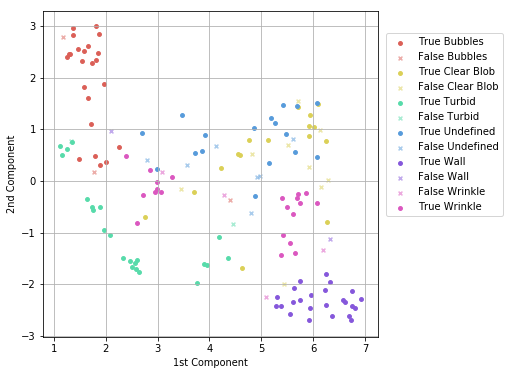

In [34]:
res.plot_colours(save=False,legend=True,filename="colours_{}".format(name))

#### 3) Plot using images

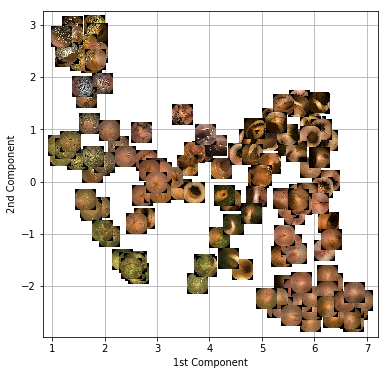

In [35]:
res.plot_images(save=False,
                eval_on=params['eval'],train_size=params['train-csize-SB2'],test_size=params['eval-csize-SB2'],
                filename="images_{}".format(name))